In [267]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import pandas as pd
import sys

import stability_functions as sf
import numpy as np
import rebound
import pandas as pd
import dask.dataframe as dd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')
# %matplotlib inline
from celmech import Andoyer

import os

In [7]:
def dfrow_to_sim(row,npl):
    sim = rebound.Simulation()
    sim.units = ('Msun','days','AU')
    sim.add(m=1)
    for i in range(npl):
        mu = row['mu{}'.format(i)]
        per = row['per{}'.format(i)]
        e = row['e{}'.format(i)]
        mean_long = row['mean_long{}'.format(i)]
        pomega = row['pomega{}'.format(i)]
        sim.add(m=mu,P=per,e=e,l=mean_long,pomega=pomega,hash=i)
    sim.move_to_com()
    sim.integrator = 'whfast'
    sim.ri_whfast.safe_mode =0
    set_timestep(sim,1/30)
#     set_min_distance(sim,3)
    set_min_distance(sim,1/2)
    return sim

def set_timestep(sim,dtFactor):
        ps=sim.particles[1:]
        Tperi=np.min([p.P * (1-p.e)**1.5 / np.sqrt(1+p.e) for p in ps])
        dt = Tperi * dtFactor
        sim.dt = dt
        
def set_min_distance(sim,rHillFactor):
        ps=sim.particles[1:]
        rHill = np.min([p.rhill for p in ps if p.m > 0])
        minDist = rHillFactor * rHill
        sim.exit_min_distance=minDist
        
def dfrow_to_Zs(row):
    sim = dfrow_to_sim(row,3)
    row['Z12'] = Andoyer.from_Simulation(sim, j=3, k=1, i1=1, i2=2).Z
    row['Z23'] = Andoyer.from_Simulation(sim, j=7, k=2, i1=2, i2=3).Z
    return row

def dfrow_to_Zs_saved(row):
    sim = rebound.SimulationArchive("K23/K23_logm_start_%d.bin"%(row[0]))[0]
    row['Z12'] = Andoyer.from_Simulation(sim, j=3, k=1, i1=1, i2=2).Z
    row['Z23'] = Andoyer.from_Simulation(sim, j=7, k=2, i1=2, i2=3).Z
    return row
    
n_workers = os.cpu_count()

In [8]:
KepID = 23
df = pd.read_csv("Kepler-{0}_default_priors.csv".format(KepID), index_col=0)
# df = df.iloc[:1000]
df['Z12'] = 0.
df['Z23'] = 0.

In [47]:
# %%time
# dasklabels = dd.from_pandas(df, npartitions=n_workers)
# df = dasklabels.apply(dfrow_to_Zs, axis=1, meta=df).compute(scheduler='processes')
# df.to_csv("Kepler-{0}_default_priors.csv".format(KepID))

CPU times: user 582 ms, sys: 256 ms, total: 838 ms
Wall time: 5min 40s


In [9]:
df = pd.read_csv("Kepler-{0}_default_priors.csv".format(KepID), index_col=0)

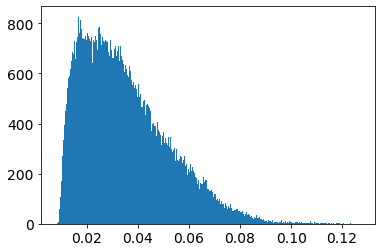

In [10]:
plt.hist(df.Z12, bins=1000);

In [11]:
np.quantile(df.Z12, 0.16)

0.01782369271753486

In [12]:
np.median(df.Z12)

0.031738126971816896

In [13]:
np.quantile(df.Z12, 0.84)

0.05263494038593203

(array([2.9749e+04, 5.8988e+04, 6.1376e+04, 4.9680e+04, 2.9190e+04,
        1.3859e+04, 4.9860e+03, 1.7560e+03, 3.6600e+02, 5.0000e+01]),
 array([3.21709582e-05, 9.18130030e-03, 1.83304296e-02, 2.74795590e-02,
        3.66286883e-02, 4.57778177e-02, 5.49269470e-02, 6.40760764e-02,
        7.32252057e-02, 8.23743351e-02, 9.15234644e-02]),
 <a list of 10 Patch objects>)

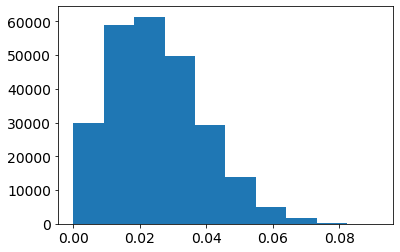

In [14]:
plt.hist(df.Z23)

In [15]:
df2 = pd.read_csv("K23/K23_logm_SPOCK.csv", index_col=0)

In [30]:
df2.head()

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,m1,m2,m3,probstability,m1+m2,m2+m3,total m
0,0.0,-0.193662,-0.285635,0.388670,0.636611,0.735677,0.664992,0.867296,0.345097,0.712553,6.213249,13.376343,40.220045,0.0,19.589593,53.596389,59.809638
1,1.0,0.342728,-0.343074,0.332211,0.559205,0.640342,0.191515,0.357091,0.484935,0.377275,0.485521,4.204200,3.251008,0.0,4.689721,7.455208,7.940729
2,2.0,0.210379,-0.115803,0.217568,0.243371,0.641480,0.408302,0.269689,0.240145,0.559020,1.452781,4.575729,11.466701,0.0,6.028510,16.042429,17.495211
3,3.0,0.024894,0.395947,0.292039,0.090441,0.257699,0.312442,0.046320,0.396729,0.026889,19.684153,3.179315,1.719421,0.0,22.863469,4.898737,24.582890
4,4.0,-0.379218,0.096536,0.209768,0.486905,0.896058,0.423220,0.227684,0.391312,0.701445,0.858439,159.849724,0.681329,0.0,160.708163,160.531053,161.389493


In [91]:
import stability_functions as sf

np.random.seed(3)
sim = sf.build_Hadden_system('K23', logm=1, loge=0)
print(sim.particles[1].e)

0.046320482970746986


In [92]:
sim.particles[2].P/sim.particles[1].P

1.5114675671872804

In [37]:
sa = rebound.SimulationArchive('K23/K23_logm_sa_471051.bin')
sa[-1].t

18114.767799779835

In [40]:
df3.shape

(7109, 17)

In [88]:
np.random.seed(0)
sim = sf.build_Hadden_system('K23', logm=1, loge=0)
ps = sim.particles
ps[1].P

0.12225762622347801

In [64]:
def pred(ID):
    ID = int(ID)
    np.random.seed(ID)
    sim = sf.build_Hadden_system('K23', logm=1, loge=0)
    return model.predict(sim)

In [65]:
def init_process():
    global model
    model = StabilityClassifier()

In [199]:
from multiprocessing import Pool
pool = Pool(processes=48, initializer=init_process)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r 

In [200]:
%%time
simIDs = df2['sim'].values
df2['probstability_fixed'] = pool.map(pred, simIDs)

CPU times: user 3.09 s, sys: 3.88 s, total: 6.96 s
Wall time: 17min 14s


In [201]:
KepID

23

In [203]:
df2.to_csv("Kepler-{0}_default_priors_SPOCK.csv".format(KepID))

In [80]:
%%time
dasklabels = dd.from_pandas(df2, npartitions=n_workers)
df2 = dasklabels.apply(dfrow_to_Zs_saved, axis=1, meta=df2).compute(scheduler='processes')
df2.to_csv("Kepler-{0}_default_priors_SPOCK.csv".format(KepID))

CPU times: user 852 ms, sys: 140 ms, total: 992 ms
Wall time: 1min 35s


In [204]:
df2 = pd.read_csv("Kepler-{0}_default_priors_SPOCK.csv".format(KepID), index_col=0)

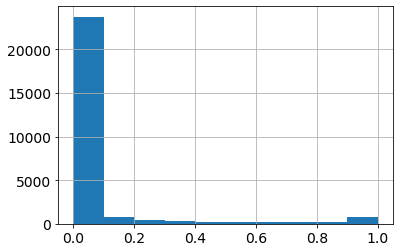

In [78]:
df2['probstability'].hist()

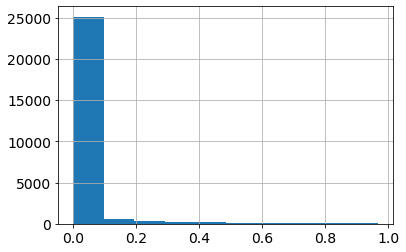

In [79]:
df2['probstability_fixed'].hist()

(array([11408.,  7131.,  2893.,  1982.,  1561.,  1062.,   523.,   304.,
          143.,    46.]),
 array([6.86754332e-04, 1.44313149e-01, 2.87939543e-01, 4.31565938e-01,
        5.75192332e-01, 7.18818727e-01, 8.62445121e-01, 1.00607152e+00,
        1.14969791e+00, 1.29332430e+00, 1.43695070e+00]),
 <a list of 10 Patch objects>)

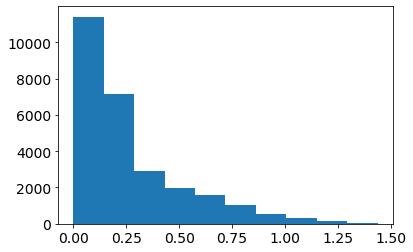

In [24]:
plt.hist(df2.Z12)

(array([413., 341., 266., 156., 122.,  63.,  29.,  13.,   5.,   4.]),
 array([0.00212553, 0.04078377, 0.079442  , 0.11810023, 0.15675846,
        0.1954167 , 0.23407493, 0.27273316, 0.31139139, 0.35004963,
        0.38870786]),
 <a list of 10 Patch objects>)

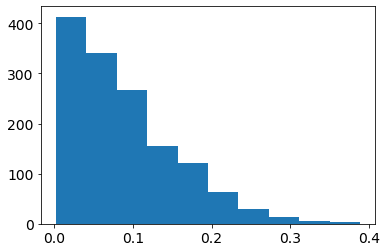

In [26]:
plt.hist(df2[df2['probstability']>0.6]['Z12'])

(array([17527.,  1830.,  2071.,  1960.,  1616.,  1062.,   567.,   279.,
          112.,    29.]),
 array([1.87317467e-04, 1.45700537e-01, 2.91213756e-01, 4.36726975e-01,
        5.82240195e-01, 7.27753414e-01, 8.73266633e-01, 1.01877985e+00,
        1.16429307e+00, 1.30980629e+00, 1.45531951e+00]),
 <a list of 10 Patch objects>)

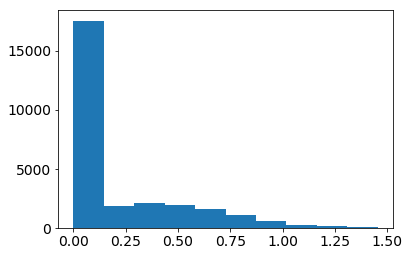

In [83]:
plt.hist(df2.Z23)

In [19]:
df3 = pd.read_csv("K23/K23_logm_nbody.csv", index_col=0)

In [90]:
%%time
dasklabels = dd.from_pandas(df3, npartitions=n_workers)
df3 = dasklabels.apply(dfrow_to_Zs_saved, axis=1, meta=df3).compute(scheduler='processes')
df3.to_csv("Kepler-{0}_default_priors_nbody.csv".format(KepID))

CPU times: user 283 ms, sys: 86 ms, total: 369 ms
Wall time: 25.7 s


In [16]:
df3 = pd.read_csv("Kepler-{0}_default_priors_nbody.csv".format(KepID), index_col=0)

### df3.head()

(array([3.097e+03, 2.443e+03, 1.075e+03, 3.810e+02, 8.300e+01, 1.900e+01,
        9.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0.00124345, 0.07479028, 0.14833711, 0.22188395, 0.29543078,
        0.36897762, 0.44252445, 0.51607129, 0.58961812, 0.66316495,
        0.73671179]),
 <a list of 10 Patch objects>)

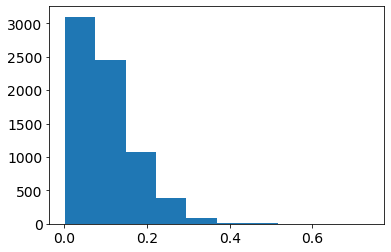

In [17]:
plt.hist(df3.Z12)

(array([6.563e+03, 4.720e+02, 0.000e+00, 1.000e+00, 2.000e+00, 4.000e+00,
        7.000e+00, 3.500e+01, 1.600e+01, 9.000e+00]),
 array([3.41437925e-04, 1.04720890e-01, 2.09100343e-01, 3.13479796e-01,
        4.17859248e-01, 5.22238701e-01, 6.26618153e-01, 7.30997606e-01,
        8.35377058e-01, 9.39756511e-01, 1.04413596e+00]),
 <a list of 10 Patch objects>)

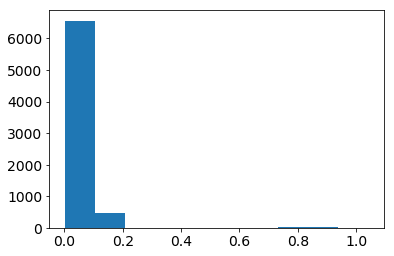

In [93]:
plt.hist(df3.Z23)

In [272]:
df2.head()

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,m1,m2,m3,probstability,m1+m2,m2+m3,total m,nbodystable,probstability_fixed,stable1e5
0,0.0,-0.193662,-0.285635,0.388702,0.636611,0.686698,0.664992,0.867296,0.345097,0.712553,6.213249,13.376343,40.220045,0.0,19.589593,53.596389,59.809638,0.0,0.0,0.0
1,1.0,0.342728,-0.343074,0.332209,0.559205,0.597740,0.191515,0.357091,0.484935,0.377275,0.485521,4.204200,3.251008,0.0,4.689721,7.455208,7.940729,0.0,0.0,0.0
2,2.0,0.210379,-0.115803,0.217567,0.243371,0.598793,0.408302,0.269689,0.240145,0.559020,1.452781,4.575729,11.466701,0.0,6.028510,16.042429,17.495211,0.0,0.0,0.0
3,3.0,0.024894,0.395947,0.292038,0.090441,0.240557,0.312442,0.046320,0.396729,0.026889,19.684153,3.179315,1.719421,0.0,22.863469,4.898737,24.582890,0.0,0.0,0.0
4,4.0,-0.379218,0.096536,0.209718,0.486905,0.836410,0.423220,0.227684,0.391312,0.701445,0.858439,159.849724,0.681329,0.0,160.708163,160.531053,161.389493,0.0,0.0,0.0


In [271]:
df3.head()

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,m1,m2,m3,probstability,m1+m2,m2+m3,total m
0,139,-0.019596,-0.101267,0.163509,0.106345,0.121643,0.076182,0.185096,0.103145,0.070585,0.681545,6.831629,2.096143,1.0,7.513174,8.927772,9.609317
1,351,-0.029971,-0.037423,0.072575,0.052489,0.004427,0.051474,0.083567,0.047945,0.045396,5.047596,74.634902,1.424302,0.0,79.682498,76.059204,81.106800
2,492,0.057219,-0.162346,0.069586,0.200627,0.110163,0.154610,0.204037,0.172134,0.073237,8.118668,7.481438,2.504023,0.0,15.600107,9.985462,18.104130
3,772,-0.028616,-0.113764,0.110277,0.131565,0.129504,0.115525,0.066358,0.117308,0.100469,0.901171,14.222821,1.288773,0.0,15.123991,15.511594,16.412765
4,798,0.092379,0.010157,0.102030,0.087493,0.087813,0.087435,0.085166,0.092935,0.096194,0.515917,2.684874,3.140176,0.0,3.200791,5.825050,6.340967


In [290]:
def t_inst(row):
    filename = 'K23/K23_logm_sa_{0}.bin'.format(int(row['sim']))
    sa = rebound.SimulationArchive(filename)
    sim0 = sa[0]
    P1 = sim0.particles[1].P
    sim = sa[-1]
    row['t_inst'] = sim.t/P1
    return row

In [291]:
%%time
df3 = df3.apply(t_inst, axis=1)

CPU times: user 2.41 s, sys: 840 ms, total: 3.25 s
Wall time: 3.17 s


In [295]:
df3['nbodystable'] = df3['t_inst'] > 9.99e8

In [299]:
df2['nbodystable_old'] = df2['nbodystable']

In [300]:
def nbodystable(row):
    ID = int(row['sim'])
    mask = np.int64(df3['sim']) == ID
    if mask.sum() == 1:
        row['stable1e5'] = 1
        row['nbodystable'] = df3[mask].nbodystable
    elif mask.sum() == 0:
        row['stable1e5'] = 0
        row['nbodystable'] = 0
    else:
        row['stable1e5'] = -1
        row['nbodystable'] = -1
    
    return row

In [263]:
sa = rebound.SimulationArchive("K23/K23_logm_start_{0}.bin".format(139))

In [264]:
sim = sa[0]

In [265]:
sim.dt/sim.particles[1].P

0.035355339059327376

In [266]:
P1 = sim.particles[1].P
try:
    sim.integrate(1e6*P1)
except:
    print(sim.t, sim.t/P1)

19890.499133466434 162693.32022779557


In [346]:
df2.shape

(27053, 21)

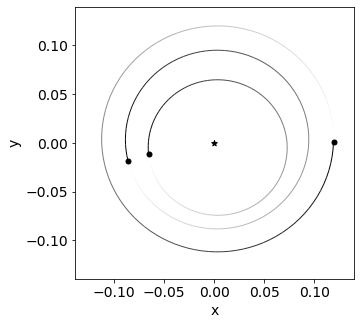

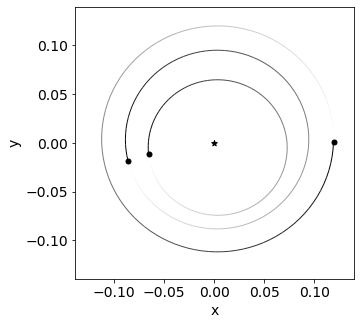

In [240]:
rebound.OrbitPlot(sa[0])

In [236]:
df3.head()

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,m1,m2,m3,probstability,m1+m2,m2+m3,total m
0,139,-0.019596,-0.101267,0.163509,0.106345,0.121643,0.076182,0.185096,0.103145,0.070585,0.681545,6.831629,2.096143,1.0,7.513174,8.927772,9.609317
1,351,-0.029971,-0.037423,0.072575,0.052489,0.004427,0.051474,0.083567,0.047945,0.045396,5.047596,74.634902,1.424302,0.0,79.682498,76.059204,81.106800
2,492,0.057219,-0.162346,0.069586,0.200627,0.110163,0.154610,0.204037,0.172134,0.073237,8.118668,7.481438,2.504023,0.0,15.600107,9.985462,18.104130
3,772,-0.028616,-0.113764,0.110277,0.131565,0.129504,0.115525,0.066358,0.117308,0.100469,0.901171,14.222821,1.288773,0.0,15.123991,15.511594,16.412765
4,798,0.092379,0.010157,0.102030,0.087493,0.087813,0.087435,0.085166,0.092935,0.096194,0.515917,2.684874,3.140176,0.0,3.200791,5.825050,6.340967


In [231]:
df3[df3['probstability']>0].head()

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,m1,m2,m3,probstability,m1+m2,m2+m3,total m
0,139,-0.019596,-0.101267,0.163509,0.106345,0.121643,0.076182,0.185096,0.103145,0.070585,0.681545,6.831629,2.096143,1.0,7.513174,8.927772,9.609317
11,2326,0.057112,0.040105,0.072933,0.101146,0.092848,0.139443,0.117674,0.069787,0.138322,4.977540,1.789392,5.841278,1.0,6.766933,7.630671,12.608211
26,6904,-0.095728,0.045344,0.215717,0.122986,0.083850,0.110917,0.222933,0.105924,0.025617,0.641098,37.823298,1.034103,1.0,38.464395,38.857401,39.498499
28,7207,0.048637,0.099467,0.146440,0.109296,0.051961,0.119166,0.106813,0.110721,0.117940,2.982307,28.664360,1.711671,1.0,31.646667,30.376031,33.358338
30,7335,-0.008795,0.027758,0.067719,0.034209,0.102457,0.111994,0.073547,0.029118,0.137543,4.218412,3.326897,6.247674,1.0,7.545308,9.574571,13.792983


In [301]:
%%time
df2 = df2.apply(nbodystable, axis=1)

CPU times: user 13.9 s, sys: 700 ms, total: 14.6 s
Wall time: 9.73 s


In [306]:
df3['probstability'].value_counts()

0.0    5920
1.0    1189
Name: probstability, dtype: int64

In [317]:
df3['nbodystable'].value_counts()

False    5930
True     1179
Name: nbodystable, dtype: int64

In [206]:
df2['nbodystable'].value_counts()

0.0    19944
1.0     7109
Name: nbodystable, dtype: int64

In [324]:
df3.head()

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,m1,m2,m3,probstability,m1+m2,m2+m3,total m,t_inst,nbodystable
0,139.0,-0.019596,-0.101267,0.163509,0.106345,0.121643,0.076182,0.185096,0.103145,0.070585,0.681545,6.831629,2.096143,1.0,7.513174,8.927772,9.609317,1.626933e+05,False
1,351.0,-0.029971,-0.037423,0.072575,0.052489,0.004427,0.051474,0.083567,0.047945,0.045396,5.047596,74.634902,1.424302,0.0,79.682498,76.059204,81.106800,1.000000e+09,True
2,492.0,0.057219,-0.162346,0.069586,0.200627,0.110163,0.154610,0.204037,0.172134,0.073237,8.118668,7.481438,2.504023,0.0,15.600107,9.985462,18.104130,2.283189e+05,False
3,772.0,-0.028616,-0.113764,0.110277,0.131565,0.129504,0.115525,0.066358,0.117308,0.100469,0.901171,14.222821,1.288773,0.0,15.123991,15.511594,16.412765,1.958412e+05,False
4,798.0,0.092379,0.010157,0.102030,0.087493,0.087813,0.087435,0.085166,0.092935,0.096194,0.515917,2.684874,3.140176,0.0,3.200791,5.825050,6.340967,2.919815e+05,False


In [325]:
df3.tail()

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,m1,m2,m3,probstability,m1+m2,m2+m3,total m,t_inst,nbodystable
7104,1998776.0,0.036849,0.098575,0.043146,0.112573,0.091209,0.078202,0.064217,0.105237,0.033132,1.355761,5.358682,2.304572,0.0,6.714443,7.663253,9.019014,1.204365e+06,False
7105,1999190.0,-0.037368,-0.069571,0.111063,0.090683,0.086250,0.085810,0.154516,0.078972,0.129648,1.179989,16.862485,1.334641,1.0,18.042474,18.197126,19.377115,4.956653e+05,False
7106,1999275.0,0.051894,-0.012013,0.163362,0.065555,0.062305,0.056360,0.269784,0.053266,0.048871,0.734743,89.384733,1.073128,0.0,90.119477,90.457862,91.192605,8.578413e+05,False
7107,1999466.0,-0.010441,0.003408,0.028842,0.012843,0.023422,0.009040,0.039781,0.010983,0.022669,0.338341,16.961854,3.006192,0.0,17.300195,19.968046,20.306386,1.000000e+09,True
7108,1999969.0,-0.010202,-0.017687,0.046017,0.032291,0.055703,0.033609,0.095140,0.020418,0.050637,1.370333,14.249430,32.821779,0.0,15.619763,47.071209,48.441542,5.152893e+05,False


In [326]:
df2.tail()

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,...,m2,m3,probstability,m1+m2,m2+m3,total m,nbodystable,probstability_fixed,stable1e5,nbodystable_old
27048,1999380.0,0.117442,-0.101202,0.201449,0.139535,0.102941,0.141930,0.198727,0.155031,0.014555,...,3.638946,0.767791,0.003473,4.439301,4.406737,5.207092,0.0,0.007788,0.0,0.0
27049,1999466.0,-0.010441,0.003408,0.028842,0.012843,0.021864,0.009040,0.039781,0.010983,0.022669,...,16.961854,3.006192,0.992900,17.300195,19.968046,20.306386,1.0,0.796429,1.0,0.0
27050,1999693.0,-0.107794,0.007459,0.075410,0.120738,0.066761,0.119870,0.088874,0.108052,0.175515,...,31.682349,1.556460,0.006749,35.493884,33.238809,37.050344,0.0,0.005343,0.0,0.0
27051,1999943.0,-0.146544,0.185455,0.130139,0.262373,0.077109,0.193714,0.224166,0.236365,0.140135,...,2.151475,6.440106,0.000814,2.683319,8.591580,9.123424,0.0,0.006733,0.0,0.0
27052,1999969.0,-0.010202,-0.017687,0.046016,0.032291,0.051997,0.033609,0.095140,0.020418,0.050637,...,14.249430,32.821779,0.009400,15.619763,47.071209,48.441542,0.0,0.012635,1.0,0.0


In [327]:
df2.shape

(27053, 21)

In [328]:
df3.head()

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,m1,m2,m3,probstability,m1+m2,m2+m3,total m,t_inst,nbodystable
0,139.0,-0.019596,-0.101267,0.163509,0.106345,0.121643,0.076182,0.185096,0.103145,0.070585,0.681545,6.831629,2.096143,1.0,7.513174,8.927772,9.609317,1.626933e+05,False
1,351.0,-0.029971,-0.037423,0.072575,0.052489,0.004427,0.051474,0.083567,0.047945,0.045396,5.047596,74.634902,1.424302,0.0,79.682498,76.059204,81.106800,1.000000e+09,True
2,492.0,0.057219,-0.162346,0.069586,0.200627,0.110163,0.154610,0.204037,0.172134,0.073237,8.118668,7.481438,2.504023,0.0,15.600107,9.985462,18.104130,2.283189e+05,False
3,772.0,-0.028616,-0.113764,0.110277,0.131565,0.129504,0.115525,0.066358,0.117308,0.100469,0.901171,14.222821,1.288773,0.0,15.123991,15.511594,16.412765,1.958412e+05,False
4,798.0,0.092379,0.010157,0.102030,0.087493,0.087813,0.087435,0.085166,0.092935,0.096194,0.515917,2.684874,3.140176,0.0,3.200791,5.825050,6.340967,2.919815e+05,False


In [342]:
filename = 'K23/K23_logm_sa_{0}.bin'.format(798)
filename

'K23/K23_logm_sa_798.bin'

In [343]:
sa = rebound.SimulationArchive('K23/K23_logm_sa_{0}.bin'.format(798))
sa[-1].t

35696.961004159086

In [338]:
sim = rebound.Simulation('K23/K23_logm_start_{0}.bin'.format(139))
sim.t

0.0

In [332]:
P1 = sim.particles[1].P
sim.integrate(2e5*P1)

Collision: Two particles collided (d < r1+r2)

In [351]:
np.int64(df3['sim'])

array([    139,     351,     492, ..., 1999275, 1999466, 1999969])

In [362]:
ID = 711738#368392#1686175#1156917
df2[np.int64(df2['sim']) == ID]

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,...,m2,m3,probstability,m1+m2,m2+m3,total m,nbodystable,probstability_fixed,stable1e5,nbodystable_old
16039,711738.0,-0.14014,0.05463,0.272258,0.078198,0.070188,0.162571,0.243993,0.150412,0.161858,...,12.578785,1.523106,0.00133,15.744895,14.101891,17.268001,0.0,0.004889,0.0,0.0


In [364]:
sa = rebound.SimulationArchive('K23uniform/K23_logm_sa_{0}.bin'.format(ID))
sim = sa[0]
P1 = sim.particles[1].P
sa[-1].t/P1

220000000.02368122

In [344]:
df3.shape

(7109, 19)

In [320]:
df3[(df3['probstability'] > 0) != (df3['nbodystable'] == True)]

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,m1,m2,m3,probstability,m1+m2,m2+m3,total m,t_inst,nbodystable
0,139.0,-0.019596,-0.101267,0.163509,0.106345,0.121643,0.076182,0.185096,0.103145,0.070585,0.681545,6.831629,2.096143,1.0,7.513174,8.927772,9.609317,1.626933e+05,False
1,351.0,-0.029971,-0.037423,0.072575,0.052489,0.004427,0.051474,0.083567,0.047945,0.045396,5.047596,74.634902,1.424302,0.0,79.682498,76.059204,81.106800,1.000000e+09,True
5,859.0,-0.021499,0.003709,0.080668,0.032526,0.021212,0.012272,0.130484,0.021816,0.008288,0.873329,6.878206,4.541916,0.0,7.751535,11.420123,12.293451,1.000000e+09,True
11,2326.0,0.057112,0.040105,0.072933,0.101146,0.092848,0.139443,0.117674,0.069787,0.138322,4.977540,1.789392,5.841278,1.0,6.766933,7.630671,12.608211,4.525672e+05,False
16,4588.0,-0.086853,0.070932,0.117591,0.135383,0.902563,0.101488,0.147208,0.112137,0.889851,2.527953,171.671954,6.995283,0.0,174.199907,178.667237,181.195190,1.000000e+09,True
25,6800.0,-0.028175,-0.077313,0.063925,0.098672,0.020631,0.087560,0.031304,0.082287,0.050802,0.400726,22.629345,0.711338,0.0,23.030071,23.340682,23.741408,1.000000e+09,True
26,6904.0,-0.095728,0.045344,0.215717,0.122986,0.083850,0.110917,0.222933,0.105924,0.025617,0.641098,37.823298,1.034103,1.0,38.464395,38.857401,39.498499,1.159308e+05,False
28,7207.0,0.048637,0.099467,0.146440,0.109296,0.051961,0.119166,0.106813,0.110721,0.117940,2.982307,28.664360,1.711671,1.0,31.646667,30.376031,33.358338,5.157045e+05,False
30,7335.0,-0.008795,0.027758,0.067719,0.034209,0.102457,0.111994,0.073547,0.029118,0.137543,4.218412,3.326897,6.247674,1.0,7.545308,9.574571,13.792983,1.912562e+05,False
33,8602.0,0.070301,0.026773,0.028394,0.055162,0.005849,0.086025,0.048076,0.075226,0.068783,7.758062,1.961815,42.375116,0.0,9.719877,44.336931,52.094993,1.000000e+09,True


In [314]:
(df3['t_inst'] < 1e5).sum()

0

In [244]:
df2.to_csv("Kepler-{0}_default_priors_SPOCK.csv".format(KepID))

# Old spock

In [307]:
np.int64(df2['nbodystable']).shape

(27053,)

In [308]:
df2.shape

(27053, 21)

Text(0.5, 1.0, 'Z12')

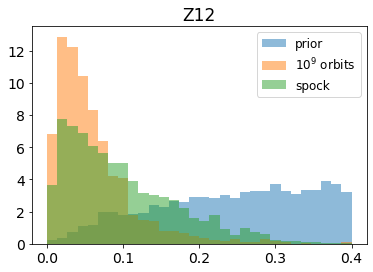

In [309]:
x, bins, x = plt.hist(df2.loc[:10000].Z12, alpha=0.5, density=True, label="prior", bins=30, range=[0,0.4])
plt.hist(df2[df2['nbodystable']>0].Z12, alpha=0.5, density=True, label=r"$10^9$ orbits", bins=bins)
# plt.hist(df3.Z12, alpha=0.5, density=True, label=r"$10^5$ orbits", bins=bins)
# plt.hist(df2.loc[df2.probstability > 0].Z12, alpha=0.5, density=True, bins=bins, label=r"$10^4$ orbits")
plt.hist(df2.Z12, alpha=0.5, density=True, bins=bins, label="spock", weights = df2.probstability)
#plt.hist(df.Z12, alpha=0.5, density=True, bins=bins, label="hadden")
plt.legend()
plt.title("Z12")

# new spock

Text(0.5, 1.0, 'Z12')

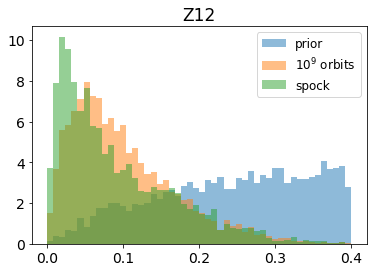

In [207]:
x, bins, x = plt.hist(df2.loc[:10000].Z12, alpha=0.5, density=True, label="prior", bins=50, range=[0,0.4])
plt.hist(df2[df2['nbodystable']>0].Z12, alpha=0.5, density=True, label=r"$10^9$ orbits", bins=bins)

# plt.hist(df3.Z12, alpha=0.5, density=True, label=r"$10^5$ orbits", bins=bins)
# plt.hist(df2.loc[df2.probstability > 0].Z12, alpha=0.5, density=True, bins=bins, label=r"$10^4$ orbits")
plt.hist(df2.Z12, alpha=0.5, density=True, bins=bins, label="spock", weights = df2.probstability_fixed)
#plt.hist(df.Z12, alpha=0.5, density=True, bins=bins, label="hadden")
plt.legend()
plt.title("Z12")

# New Nbody stable

Text(0.5, 1.0, 'Z12')

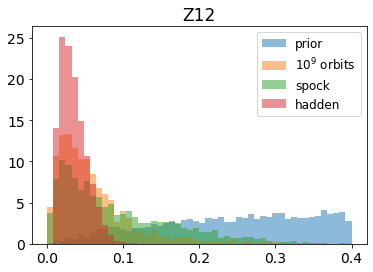

In [365]:
x, bins, x = plt.hist(df2.loc[:10000].Z12, alpha=0.5, density=True, label="prior", bins=50, range=[0,0.4])
plt.hist(df2[df2['nbodystable']>0].Z12, alpha=0.5, density=True, label=r"$10^9$ orbits", bins=bins)

# plt.hist(df3.Z12, alpha=0.5, density=True, label=r"$10^5$ orbits", bins=bins)
# plt.hist(df2.loc[df2.probstability > 0].Z12, alpha=0.5, density=True, bins=bins, label=r"$10^4$ orbits")
plt.hist(df2.Z12, alpha=0.5, density=True, bins=bins, label="spock", weights = df2.probstability_fixed)
plt.hist(df.Z12, alpha=0.5, density=True, bins=bins, label="hadden")
plt.legend()
plt.title("Z12")

In [206]:
df2['nbodystable'].value_counts()

0.0    19944
1.0     7109
Name: nbodystable, dtype: int64

In [247]:
df2.loc[139]

sim                    139.000000
k                       -0.019596
h                       -0.101267
Z12                      0.163512
Zcom12                   0.106345
Z23                      0.113550
Zcom23                   0.076182
e1                       0.185096
e2                       0.103145
e3                       0.070585
m1                       0.681545
m2                       6.831629
m3                       2.096143
probstability            0.003420
m1+m2                    7.513174
m2+m3                    8.927772
total m                  9.609317
nbodystable              1.000000
probstability_fixed      0.013039
stable1e5                1.000000
Name: 139, dtype: float64

In [245]:
(df2[df2['nbodystable'] > 0]['probstability_fixed'] < 1.e-5).sum()

70

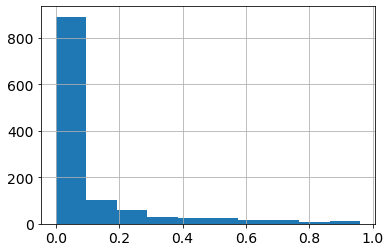

In [246]:
df2[df2['nbodystable'] > 0]['probstability_fixed'].hist()

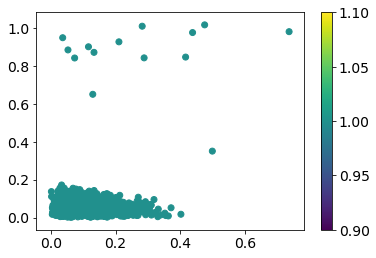

In [110]:
stable = df3['probstability'] > 0

fig, ax = plt.subplots()
cb = ax.scatter(df3[stable].Z12, df3[stable].Z23,c=df3[stable].probstability)
fig.colorbar(cb)

# Figure out why large e Nbodys survive

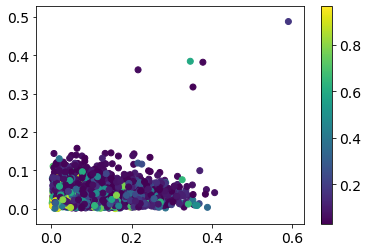

In [114]:
pstable = df2['probstability_fixed'] > 0.03
           
fig, ax = plt.subplots()
cb = ax.scatter(df2[pstable].Z12, df2[pstable].Z23,c=df2[pstable].probstability_fixed)
fig.colorbar(cb)

Text(0.5, 0, '$Z_{12}$')

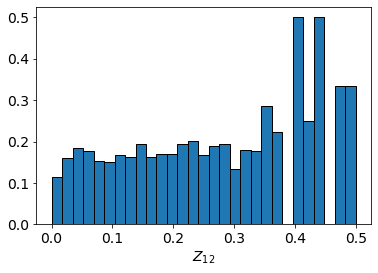

In [101]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots()
Nbins=30
bins = np.linspace(0, 0.5, Nbins)
f_stable, edges = np.histogram(df3.loc[df3.probstability > 0].Z12, bins)
f, edges = np.histogram(df3.Z12, bins)
ax.bar(edges[:-1], f_stable/f, width=np.diff(edges), edgecolor="black", align="edge")
ax.set_xlabel(r'$Z_{12}$')

Text(0.5, 0, '$Z_{12}$')

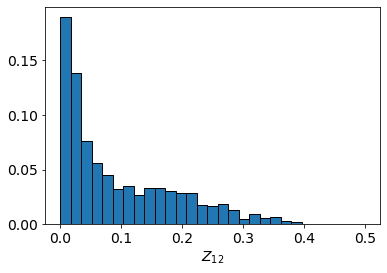

In [117]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots()
Nbins=30
bins = np.linspace(0, 0.5, Nbins)
f_stable, edges = np.histogram(df2.Z12, bins, weights=df2['probstability_fixed'])
f, edges = np.histogram(df2.Z12, bins)
ax.bar(edges[:-1], f_stable/f, width=np.diff(edges), edgecolor="black", align="edge")
ax.set_xlabel(r'$Z_{12}$')

In [120]:
df3.shape

(7109, 17)

In [121]:
df2.shape

(27053, 18)

In [95]:
t = df3[df3.Z12 > 0.4]
t['probstability'].sum()

6.0

In [147]:
np.quantile(df3.loc[df3.probstability > 0].Z12, 0.84)
np.quantile(df3.loc[df3.probstability > 0].Z23, 0.84)

0.08770775442418524

# Old spock

Text(0.5, 1.0, 'Z23')

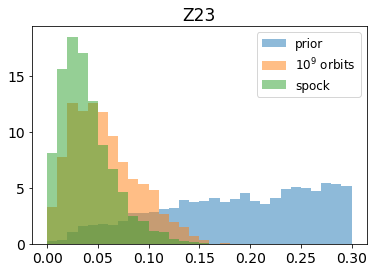

In [85]:
x, bins, x = plt.hist(df2.loc[:10000].Z23, alpha=0.5, density=True, label="prior", bins=30, range=[0,0.3])
plt.hist(df3.loc[df3.probstability > 0].Z23, alpha=0.5, density=True, label=r"$10^9$ orbits", bins=bins)
# plt.hist(df3.Z23, alpha=0.5, density=True, label=r"$10^5$ orbits", bins=bins)
# plt.hist(df2.loc[df2.probstability > 0].Z23, alpha=0.5, density=True, bins=bins, label=r"$10^4$ orbits")
plt.hist(df2.Z23, alpha=0.5, density=True, bins=bins, label="spock", weights = df2.probstability)
# plt.hist(df.Z23, alpha=0.5, density=True, bins=bins, label="hadden")
plt.legend()
plt.title("Z23")

# new spock

Text(0.5, 1.0, 'Z23')

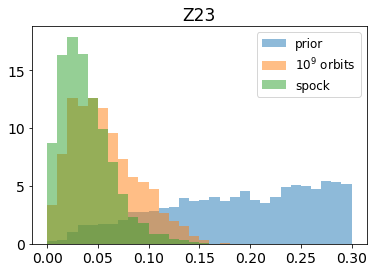

In [84]:
x, bins, x = plt.hist(df2.loc[:10000].Z23, alpha=0.5, density=True, label="prior", bins=30, range=[0,0.3])
plt.hist(df3.loc[df3.probstability > 0].Z23, alpha=0.5, density=True, label=r"$10^9$ orbits", bins=bins)
# plt.hist(df3.Z23, alpha=0.5, density=True, label=r"$10^5$ orbits", bins=bins)
# plt.hist(df2.loc[df2.probstability > 0].Z23, alpha=0.5, density=True, bins=bins, label=r"$10^4$ orbits")
plt.hist(df2.Z23, alpha=0.5, density=True, bins=bins, label="spock", weights = df2.probstability_fixed)
# plt.hist(df.Z23, alpha=0.5, density=True, bins=bins, label="hadden")
plt.legend()
plt.title("Z23")

Text(0.5, 1.0, 'Z23')

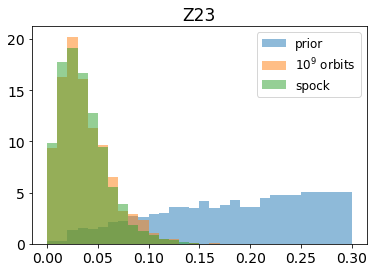

In [312]:
x, bins, x = plt.hist(df2.loc[:10000].Z23, alpha=0.5, density=True, label="prior", bins=30, range=[0,0.3])
plt.hist(df2[df2['nbodystable']>0].Z23, alpha=0.5, density=True, label=r"$10^9$ orbits", bins=bins)
# plt.hist(df3.Z23, alpha=0.5, density=True, label=r"$10^5$ orbits", bins=bins)
# plt.hist(df2.loc[df2.probstability > 0].Z23, alpha=0.5, density=True, bins=bins, label=r"$10^4$ orbits")
plt.hist(df2.Z23, alpha=0.5, density=True, bins=bins, label="spock", weights = df2.probstability_fixed)
# plt.hist(df.Z23, alpha=0.5, density=True, bins=bins, label="hadden")
plt.legend()
plt.title("Z23")

In [130]:
df2.loc[139]

sim                    139.000000
k                       -0.019596
h                       -0.101267
Z12                      0.163509
Zcom12                   0.106345
Z23                      0.121643
Zcom23                   0.076182
e1                       0.185096
e2                       0.103145
e3                       0.070585
m1                       0.681545
m2                       6.831629
m3                       2.096143
probstability            0.003420
m1+m2                    7.513174
m2+m3                    8.927772
total m                  9.609317
probstability_fixed      0.013039
Name: 139, dtype: float64

In [131]:
df3.tail()

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,m1,m2,m3,probstability,m1+m2,m2+m3,total m
7104,1998776.0,0.036849,0.098575,0.043146,0.112573,0.091209,0.078202,0.064217,0.105237,0.033132,1.355761,5.358682,2.304572,0.0,6.714443,7.663253,9.019014
7105,1999190.0,-0.037368,-0.069571,0.111063,0.090683,0.086250,0.085810,0.154516,0.078972,0.129648,1.179989,16.862485,1.334641,1.0,18.042474,18.197126,19.377115
7106,1999275.0,0.051894,-0.012013,0.163362,0.065555,0.062305,0.056360,0.269784,0.053266,0.048871,0.734743,89.384733,1.073128,0.0,90.119477,90.457862,91.192605
7107,1999466.0,-0.010441,0.003408,0.028842,0.012843,0.023422,0.009040,0.039781,0.010983,0.022669,0.338341,16.961854,3.006192,0.0,17.300195,19.968046,20.306386
7108,1999969.0,-0.010202,-0.017687,0.046017,0.032291,0.055703,0.033609,0.095140,0.020418,0.050637,1.370333,14.249430,32.821779,0.0,15.619763,47.071209,48.441542


In [132]:
df2.tail()

,sim,k,h,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,m1,m2,m3,probstability,m1+m2,m2+m3,total m,probstability_fixed
27048,1999380.0,0.117442,-0.101202,0.201449,0.139535,0.110277,0.141930,0.198727,0.155031,0.014555,0.800355,3.638946,0.767791,0.003473,4.439301,4.406737,5.207092,0.007788
27049,1999466.0,-0.010441,0.003408,0.028842,0.012843,0.023422,0.009040,0.039781,0.010983,0.022669,0.338341,16.961854,3.006192,0.992900,17.300195,19.968046,20.306386,0.796429
27050,1999693.0,-0.107794,0.007459,0.075412,0.120738,0.071519,0.119870,0.088874,0.108052,0.175515,3.811535,31.682349,1.556460,0.006749,35.493884,33.238809,37.050344,0.005343
27051,1999943.0,-0.146544,0.185455,0.130139,0.262373,0.082599,0.193714,0.224166,0.236365,0.140135,0.531844,2.151475,6.440106,0.000814,2.683319,8.591580,9.123424,0.006733
27052,1999969.0,-0.010202,-0.017687,0.046017,0.032291,0.055703,0.033609,0.095140,0.020418,0.050637,1.370333,14.249430,32.821779,0.009400,15.619763,47.071209,48.441542,0.012635


In [114]:
df4 = df3.loc[df3.probstability > 0]
df4 = df4.loc[df4.Z12 > 0.25]

In [136]:
df4;

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae7a6e3fd0>)

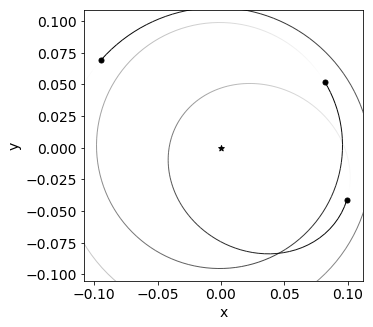

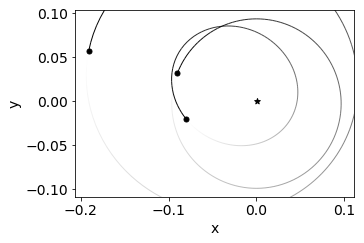

In [138]:
sim = rebound.SimulationArchive("K23/K23_logm_start_%d.bin"%(int(df4.sim.iloc[0])))[0]
rebound.OrbitPlot(sim)
P1 = sim.particles[1].P
maxorbs = 1e6
sim.integrate(maxorbs * P1, exact_finish_time=0)
rebound.OrbitPlot(sim)

In [143]:
sim = rebound.SimulationArchive("K23/K23_logm_start_%d.bin"%(int(df4.sim.iloc[0])))[0]
sim.status()

---------------------------------
REBOUND version:     	3.12.1
REBOUND built on:    	Mar 17 2020 15:28:58
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.004322
---------------------------------
<rebound.Particle object, m=1.055829268737029 x=-6.943939601097393e-06 y=-4.424962041816582e-06 z=2.021073987697693e-08 vx=0.00014755501084640118 vy=-0.0002379244931923872 vz=5.243681923140896e-06>
<rebound.Particle object, m=4.16932561680511e-06 x=0.09920050660794036 y=-0.04162269512779508 z=0.0007410123772195609 vx=0.693439582259841 vy=2.193409158582374 vz=-0.04591066073455772>
<rebound.Particle object, m=8.863647054784092e-05 x=0.08191852207752205 y=0.05183126567123616 z=-0.00033048129214195915 vx=-1.7068628710729172 vy=2.825140240627406 vz=-0.05981850640832024>
<rebound.Particle object, m=3.6317427139575493e-06 x=-0.09443213318737342 y=0.06922366822546742 z=0.0013393247013907276 vx=-2.0358749492327943 vy=-2.2985805219